In [1]:
import keras
import tensorflow as tf
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time

Using TensorFlow backend.


# Préparation des données

Nous chargeons le dataset du Fashion MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Nous avons 60k d'exemples dans le trainset, chacun de taille 28x28. Nous avons aussi les 60k étiquettes du trainset. Ici, les étuiquettes ne sont pas en format one hot nous allons donc les transformer. De plus, nous allons normaliser les entrés des images en les divisant par 255 soit la valeur maximale pour avoir un input entre 0 et 1. 

In [3]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


Nous avons 10k d'exemples dans le testset, chacun de taille 28x28.

Nous allons séparer le test set pour créer une validation set de taille égale.

In [4]:
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [5]:
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [6]:
print(x_validation.shape)
print(y_validation.shape)

(5000, 28, 28)
(5000,)


In [7]:
print(x_test.shape)
print(y_test.shape)

(5000, 28, 28)
(5000,)


On scale les images entre 0 et 1.

In [8]:
ohe = OneHotEncoder(categories="auto",sparse=False)
ohe.fit(y_train.reshape(-1, 1))
x_train, x_validation, x_test = x_train/255, x_validation/255, x_test/255
y_train, y_validation, y_test = ohe.transform(y_train.reshape(-1, 1)), ohe.transform(y_validation.reshape(-1, 1)), ohe.transform(y_test.reshape(-1, 1))
print(np.min(x_train))
print(np.max(x_train))
print(y_train.shape)

0.0
1.0
(60000, 10)


Nous avons bien 10 classes et nous avons scalé les features de images. Nous avons un ensemble de test, de validation et de test. Il ne reste plus que reshape les images pour notre réseau dense pour avoir une entrée de taille 28**2.

In [9]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]**2)
x_validation = x_validation.reshape(x_validation.shape[0],x_validation.shape[1]**2)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]**2)

In [10]:
x_train = np.array(x_train,dtype=np.float32)
x_validation = np.array(x_validation,dtype=np.float32)
x_test = np.array(x_test,dtype=np.float32)

In [11]:
y_train = np.array(y_train,dtype=np.float32)
y_validation = np.array(y_validation,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)


Dans cette partie, nous explorerons un réseau de neuronnes de type Dense soit fully connected.

In [12]:
# https://github.com/frank1789/NeuralNetworks/blob/master/staticsanalysis.py

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Min Training loss (' + str(str(format(np.min(history.history[l]),'.5f'))+') at epoch '+ str(str(format(np.argmin(history.history[l]),'d')))))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Min Validation loss (' + str(str(format(np.min(history.history[l]),'.5f'))+') at epoch '+ str(str(format(np.argmin(history.history[l]),'d')))))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Max Training Acc (' + str(str(format(np.max(history.history[l]),'.5f'))+') at epoch '+ str(str(format(np.argmax(history.history[l]),'d')))))
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Max Validation Acc (' + str(str(format(np.max(history.history[l]),'.5f'))+') at epoch '+ str(str(format(np.argmax(history.history[l]),'d')))))

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Fonction qui crée un modèle MLP en fonction des paramètres passé dans la fonction.

In [13]:
def create_model(hidden_layer_number=1, neurons=100, activation='relu', dropout=0, batchnorm=False, optimizer='adam',l1=0,l2=0):
    
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=28**2, kernel_initializer='uniform',
                    activation=activation, kernel_regularizer=l1_l2(l1,l2)))
    if dropout >0:
        model.add(Dropout(dropout)) 
    
    if batchnorm:
        model.add(BatchNormalization())

    if hidden_layer_number>1:
        for i in range(hidden_layer_number-1):
            model.add(Dense(neurons, kernel_initializer='uniform',
                            activation=activation, kernel_regularizer=l1_l2(l1,l2)))
            if dropout >0:
                model.add(Dropout(dropout))        

            if batchnorm:
                model.add(BatchNormalization())
    
    model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

### Callbacks

Nous allons réduire le learning rate lorsqu'un plateau est atteint et nous allons mettre un early stopping lorsque la perte du set de validation cesse de diminuer

In [14]:
lr_reducer = ReduceLROnPlateau(factor=0.7,
                               cooldown=0,
                               patience=10,
                               min_lr=0.5e-6)
callbacks = [EarlyStopping(monitor='val_loss', patience=50), lr_reducer]

### Seeds

Nous allons fixer les seeds pour avoir des expériences reproductibles

In [15]:
best = 1000000

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Partie DENSE

### Effet neuronnes cachées

Nous allons commencer par observer l'effet du nombre de neuronnes cachées sur l'apprentissage d'un réseau une couche.

number of parameters: 39760


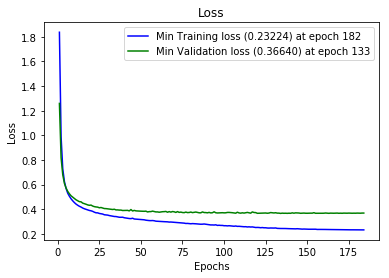

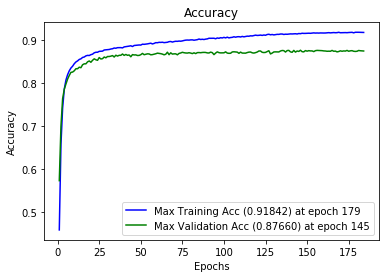

total time: 103.04144477844238


In [30]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=50, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 1: 1 couche 50 neurones

number of parameters: 79510


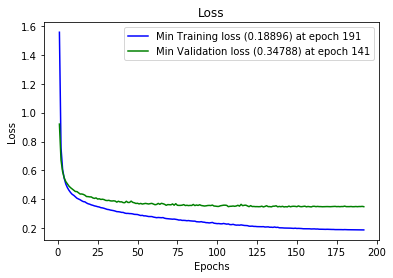

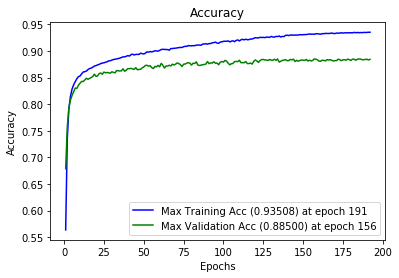

total time: 108.60258841514587


In [31]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=100, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 2: 1 couche 100 neurones

number of parameters: 198760


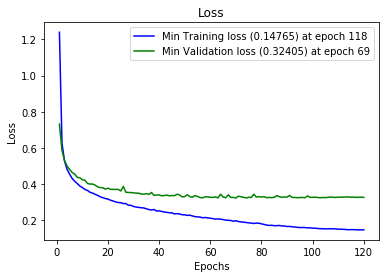

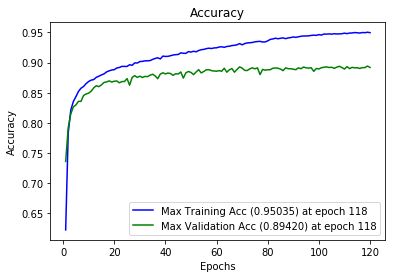

total time: 70.32553744316101


In [32]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=250, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 3: 1 couche 250 neurones

number of parameters: 397510


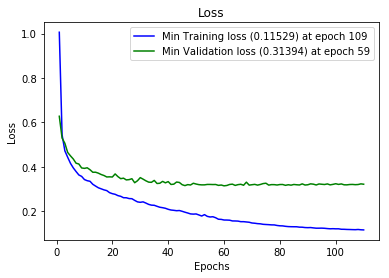

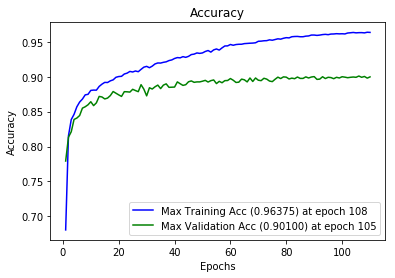

total time: 63.53756809234619


In [72]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 4: 1 couche 500 neurones

number of parameters: 795010


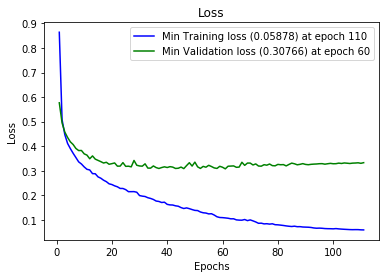

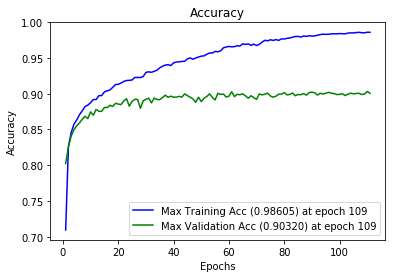

total time: 70.91481161117554


In [73]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=1000, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 5: 1 couche 1000 neurones

number of parameters: 1192510


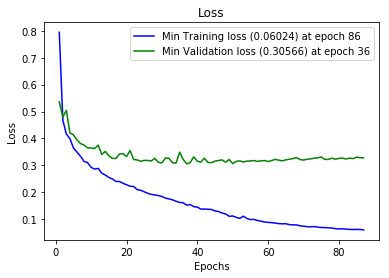

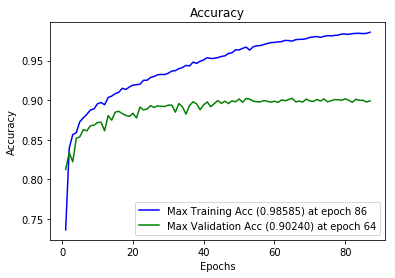

total time: 58.07013130187988


In [23]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=1500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 6: 1 couche 1500 neurones

Nous allons garder environ 1millions de paramètres pour toutes les expériences de manière à avoir des réseaux comparable. Un million de paramètres est choisis car le réseau a un bon validation loss ainsi que validation accuracy comparé aux autres réseaux. Au départ l'augmentation du nombre de neuronnes cachées augmente les performances, mais à partir de 1000, la performance n'augmente pas beaucoup.

### Effet batch size

Nous allons maintenant regarder l'effet du batch size sur la performance du modèle. La batch size de 2048 a déjà été testé sur le modèle précédant elle ne sera donc pas resté.

number of parameters: 1192510


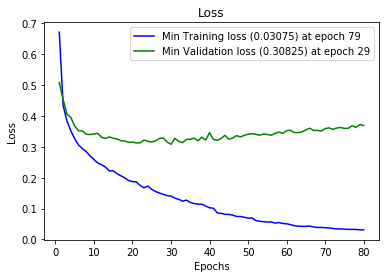

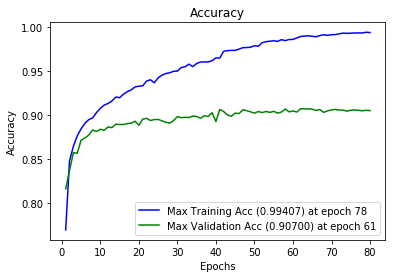

total time: 71.3544089794159


In [17]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=1500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 7: 1 couche 1500 neurones batch size 1024

number of parameters: 1192510


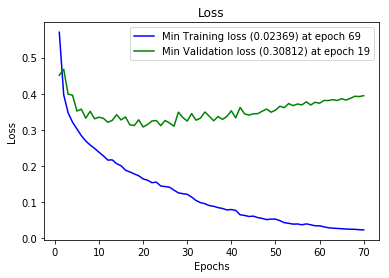

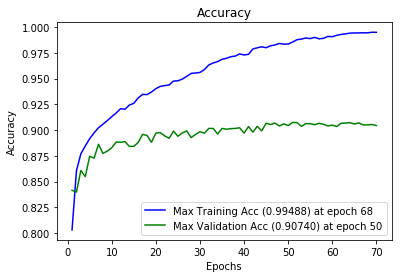

total time: 82.90978622436523


In [18]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=1500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 7: 1 couche 1500 neurones batch size 512

number of parameters: 1192510


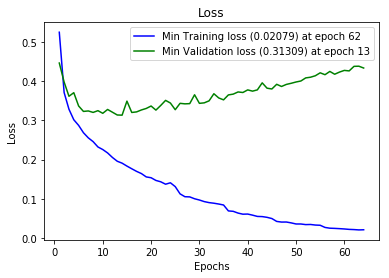

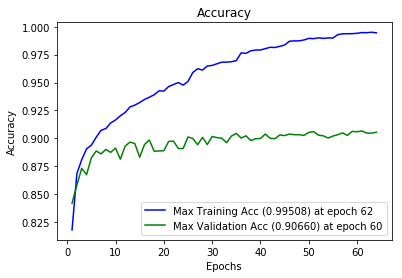

total time: 128.42630624771118


In [19]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=1500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=256, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 8: 1 couche 1500 neurones batch size 256

La taille de minibatch qui a obtenue les meilleurs résultats est celle de 1024, elle sera gardé pour le reste des expériences des réseaux denses.

### Effet profondeur

Dans cette section nous allons regarder l'effet de la profondeur du réseau sur la performance en concervant le nombre de paramètres constant.

number of parameters: 1159510


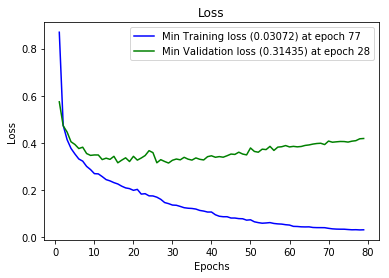

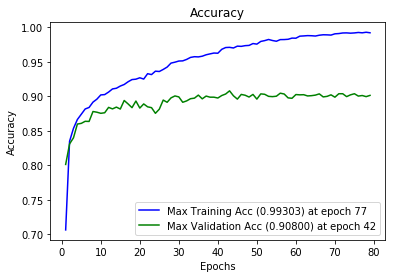

total time: 57.717485189437866


In [27]:
start = time.time()
model = create_model(hidden_layer_number=2, neurons=750, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 9: 2 couches cachées

number of parameters: 1198210


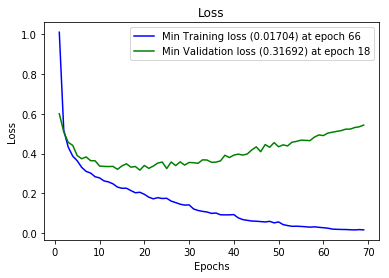

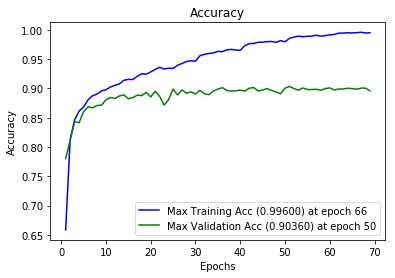

total time: 51.636571168899536


In [29]:
start = time.time()
model = create_model(hidden_layer_number=3, neurons=600, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 10: 3 couches cachées

number of parameters: 1149010


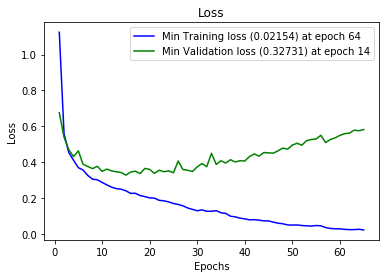

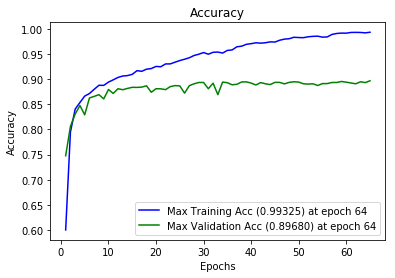

total time: 50.259227991104126


In [31]:
start = time.time()
model = create_model(hidden_layer_number=4, neurons=500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 11: 4 couches cachées

number of parameters: 1211935


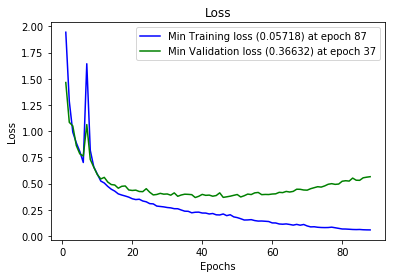

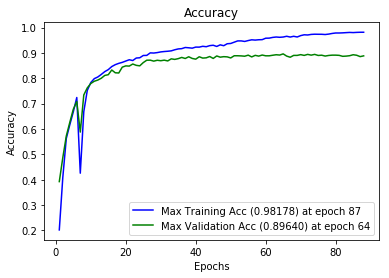

total time: 77.15779709815979


In [34]:
start = time.time()
model = create_model(hidden_layer_number=10, neurons=325, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 12: 10 couches cachées

number of parameters: 1211935


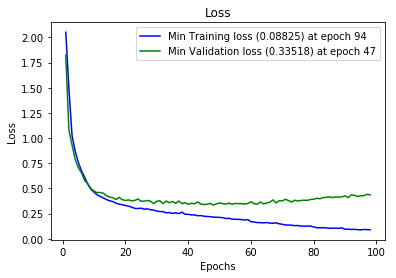

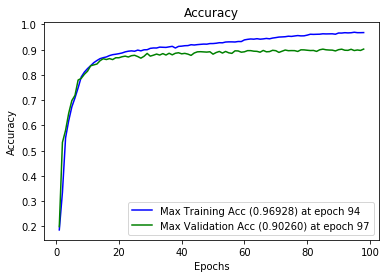

total time: 100.46095085144043


In [35]:
start = time.time()
model = create_model(hidden_layer_number=10, neurons=325, activation='relu', dropout=0.1, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 13: 10 couches cachées avec dropout


number of parameters: 1211935


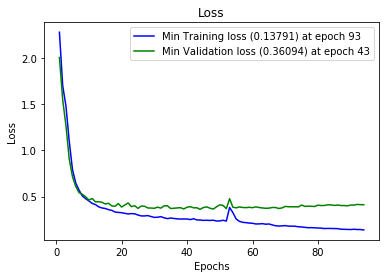

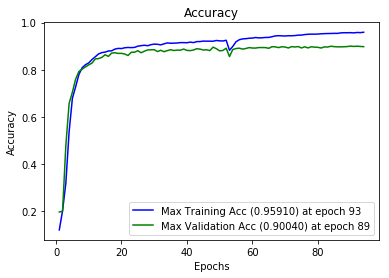

total time: 96.89271140098572


In [23]:
start = time.time()
model = create_model(hidden_layer_number=10, neurons=325, activation='relu', dropout=0.1, batchnorm=False, optimizer='adam',l1=0.000001,l2=0.000001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 14: 10 couches cachées avec dropout avec elastic net


number of parameters: 1224935


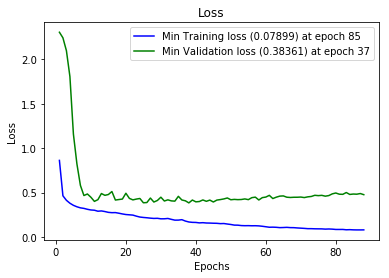

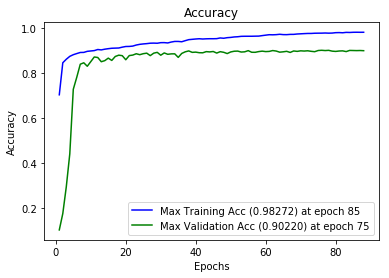

total time: 144.27773356437683


In [25]:
start = time.time()
model = create_model(hidden_layer_number=10, neurons=325, activation='relu', dropout=0.1, batchnorm=True, optimizer='adam',l1=0.000001,l2=0.000001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 15: 10 couches cachées avec dropout avec elastic net et batchnorm

number of parameters: 1116655


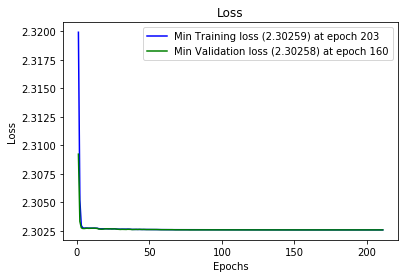

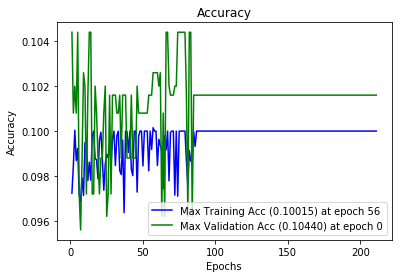

total time: 231.8726246356964


In [24]:
start = time.time()
model = create_model(hidden_layer_number=15, neurons=255, activation='relu', dropout=0.1, batchnorm=False, optimizer='adam',l1=0.000001,l2=0.000001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 16: 15 couches cachées avec dropout avec elastic net

number of parameters: 1131955


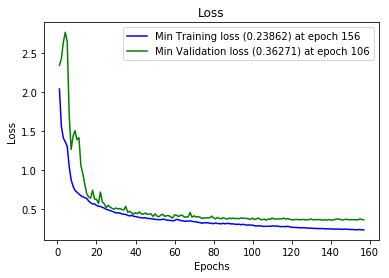

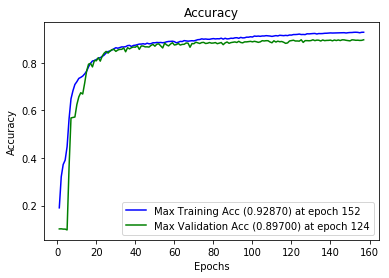

total time: 312.10143876075745


In [26]:
start = time.time()
model = create_model(hidden_layer_number=15, neurons=255, activation='relu', dropout=0.3, batchnorm=True, optimizer='adam',l1=0.000001,l2=0.000001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 17: 15 couches cachées avec dropout avec elastic net et batchnorm

En ajoutant batchnorm il est possible d'avoir une descente de gradient qui est n'explose pas ou ne disparait pas. Le réseau est donc en mesure d'apprendre

number of parameters: 1098690


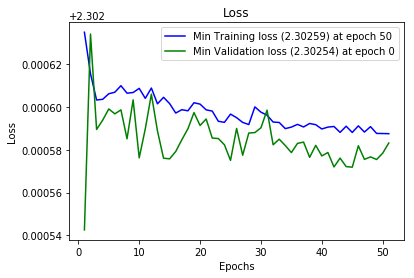

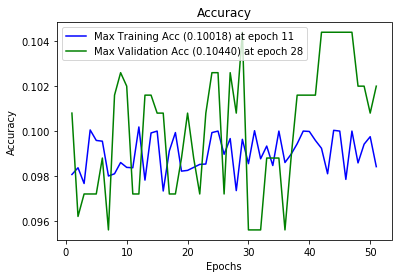

total time: 68.83352327346802


In [38]:
start = time.time()
model = create_model(hidden_layer_number=20, neurons=220, activation='relu', dropout=0.3, batchnorm=True, optimizer='adam',l1=0.000001,l2=0.000001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 18: 20 couches cachées avec dropout avec elastic net et batchnorm

### Gradient clipping

In [27]:
from keras import optimizers

In [28]:
def create_model(hidden_layer_number=1, neurons=100, activation='relu', dropout=0, batchnorm=False, optimizer='adam',l1=0,l2=0):
    
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=28**2, kernel_initializer='uniform',
                    activation=activation, kernel_regularizer=l1_l2(l1,l2)))
    if dropout >0:
        model.add(Dropout(dropout)) 
    
    if batchnorm:
        model.add(BatchNormalization())

    if hidden_layer_number>1:
        for i in range(hidden_layer_number-1):
            model.add(Dense(neurons, kernel_initializer='uniform',
                            activation=activation, kernel_regularizer=l1_l2(l1,l2)))
            if dropout >0:
                model.add(Dropout(dropout))        

            if batchnorm:
                model.add(BatchNormalization())
    
    model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(clipnorm=.99), metrics=['accuracy'])
    
    return model

number of parameters: 1116290


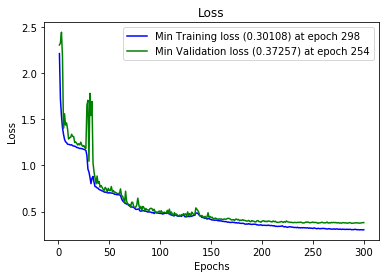

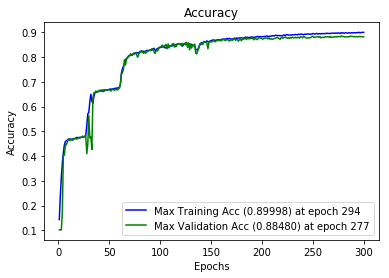

total time: 780.3263666629791


In [29]:
start = time.time()
model = create_model(hidden_layer_number=20, neurons=220, activation='relu', dropout=0.3, batchnorm=True, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 19: 20 couches cachées avec dropout , batchnorm et gradient clipping

# Architecture en entonnoire

In [44]:
activation='relu'
dropout=0.1
batchnorm=False
optimizer='adam'
l1=0
l2=0
model = Sequential()
model.add(Dense(1500, input_dim=28**2, kernel_initializer='uniform',
                activation=activation, kernel_regularizer=l1_l2(l1,l2)))
model.add(Dropout(dropout)) 

model.add(Dense(500, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))        

model.add(Dense(250, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))  

model.add(Dense(200, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))     

model.add(Dense(150, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))    

model.add(Dense(100, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))     


model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


number of parameters: 2149710


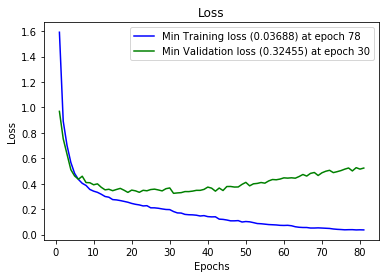

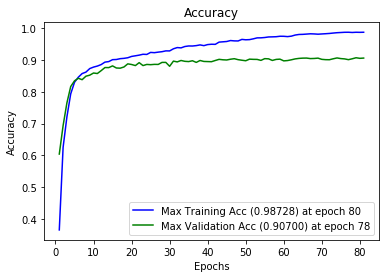

total time: 86.7406256198883


In [45]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 20: Architecture en entonnoire

### Conclusion MLP

Un réseau profond dans cette situation ne permet pas d'avoir de meilleur résultat comparé à un réseau une couche. De plus, nous avons vu qu'en appliquant de la régularisation comme du dropout ou du Batchnormalisation, il est possible d'avoir des réseaux plus profond qui sont encore capable d'apprendre. Aussi, en appliquant du gradient clipping, il est possible d'avoir un réseau de 20couches qui apprend. Malgré tout, le réseaux de 20 couches n'apporte pas de meilleurs résultats. Peut-être qu'en augmentant le nombre de neuronnes cachées dans les premières couches le résultat serait meilleur pour celui-ci. 

# Partie CNN

Dans cette section, nous essayerons differente architecture de CNN. Nous essayerons aussi des layers de types inception. Nous utiliserons des minibatch de 512 à cause de la mémoire de la carte graphique.

In [35]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, \
    GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, Convolution2D, \
    MaxPool2D, concatenate, AveragePooling2D, Flatten, InputLayer
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers
from keras.models import Model
import numpy as np 
from keras import backend as K 
from keras.utils import np_utils
import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [106]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Nous refaisons le preprocessing, mais cette fois ci, la dimension de la matrice est changé pour 60000x28x28x1 par exemple, pour pouvoir utiliser les rentrer dans le CNN. 

In [107]:
ohe = OneHotEncoder(categories="auto",sparse=False)
ohe.fit(y_train.reshape(-1, 1))
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train = x_train.reshape(60000,28,28,1)
x_validation = x_validation.reshape(5000,28,28,1)
x_test = x_test.reshape(5000,28,28,1)

x_train, x_validation, x_test = x_train/255, x_validation/255, x_test/255
y_train, y_validation, y_test = ohe.transform(y_train.reshape(-1, 1)), ohe.transform(y_validation.reshape(-1, 1)), ohe.transform(y_test.reshape(-1, 1))

In [38]:
# https://github.com/cmasch/zalando-fashion-mnist

def create_model():
   
    cnn = Sequential()
    
    cnn.add(InputLayer(input_shape=(28,28,1)))
    
    # Normalization
    cnn.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(Flatten())

    # Fully Connected Layer
    cnn.add(Dense(256, activation='relu'))

    # Dropout
    cnn.add(Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(BatchNormalization())

    cnn.add(Dense(10, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

    return cnn

model = create_model()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


number of parameters: 493902


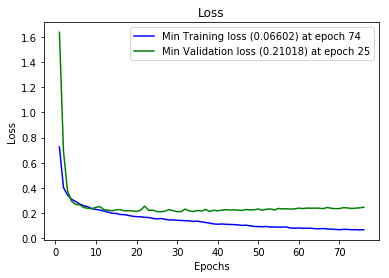

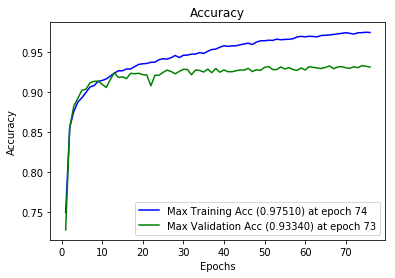

total time: 431.16297721862793


In [39]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=100, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 21: Architecture CNN de base 1

Déjà avec une réseau CNN de base, les performances se voit grandement augmenté par rapport au réseau dense. Accuracy de validation augmenté de 2.5%

In [40]:
def create_model():
   
    cnn = Sequential()
    
    cnn.add(InputLayer(input_shape=(28,28,1)))
    
    # Normalization
    cnn.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(128, (4, 4), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(128, (4, 4), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(Flatten())

    # Fully Connected Layer
    cnn.add(Dense(256, activation='relu'))

    # Dropout
    cnn.add(Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(BatchNormalization())

    cnn.add(Dense(10, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

    return cnn

model = create_model()

number of parameters: 1101262


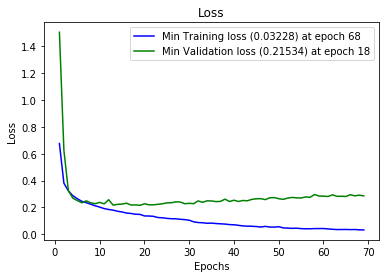

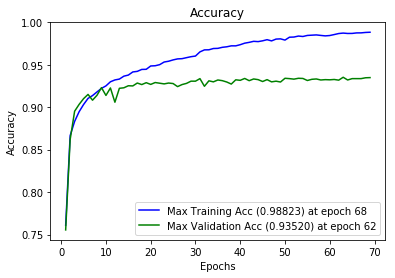

total time: 676.217098236084


In [41]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=100, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 22: Architecture CNN de base 2

En augmentant la taille du réseau les résultats sont similaires.

### Inception layer

Dans cette section nous essayerons les couches de type inception dans notre réseau CNN. 

In [42]:
# https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [48]:
def create_model():
    '''
    Creates a sequential model
    '''
    
    input_layer = Input(shape=(28, 28, 1))

    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

    x = inception_module(x,
                         filters_1x1=384,
                         filters_3x3_reduce=192,
                         filters_3x3=384,
                         filters_5x5_reduce=48,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_1')    

    x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

    x = Dropout(0.4)(x)

    x = Dense(10, activation='softmax', name='output')(x)
    model = Model(input_layer, x, name='inception_v1')
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(), metrics=['accuracy'])
    return model


model = create_model()

### Une couche inception

number of parameters: 1091194


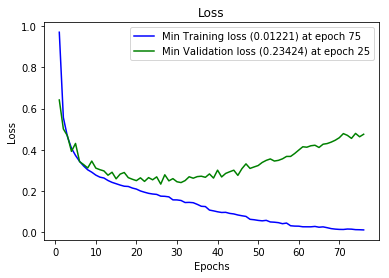

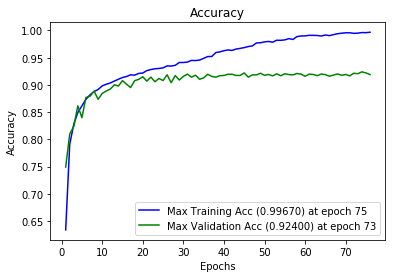

total time: 480.5119755268097


In [49]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 23: Architecture CNN avec une couche inception

In [55]:
def create_model():
    '''
    Creates a sequential model
    '''
    
    input_layer = Input(shape=(28, 28, 1))

    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

    x = inception_module(x,
                         filters_1x1=192,
                         filters_3x3_reduce=128,
                         filters_3x3=192,
                         filters_5x5_reduce=32,
                         filters_5x5=64,
                         filters_pool_proj=32,
                         name='inception_1')
    
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/1')(x)

    x = inception_module(x,
                         filters_1x1=128,
                         filters_3x3_reduce=128,
                         filters_3x3=192,
                         filters_5x5_reduce=32,
                         filters_5x5=96,
                         filters_pool_proj=64,
                         name='inception_2')

    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

    x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

    x = Dropout(0.4)(x)

    x = Dense(10, activation='softmax', name='output')(x)
    model = Model(input_layer, x, name='inception_v1')
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(), metrics=['accuracy'])
    return model


model = create_model()

### deux couches inceptions

number of parameters: 937290


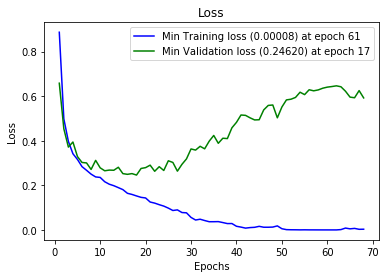

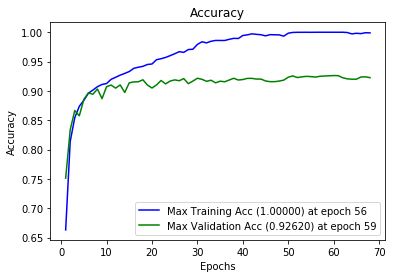

total time: 490.4862320423126


In [56]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 24: Architecture CNN avec deux couches inception

## Data augmentation

https://github.com/cmasch/zalando-fashion-mnist/blob/master/Simple_Convolutional_Neural_Network_Fashion-MNIST.ipynb

Nous allons augmenter nos données en faisant un horizontal flip des données. Nous aurions aussi pu faire des random crop ou autres, mais le horizontal flip sera suffisant.

In [90]:
x_train.shape

(60000, 28, 28, 1)

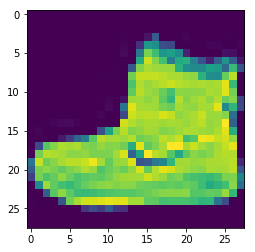

In [91]:
plt.imshow(x_train[0,:,:,0])
plt.show()

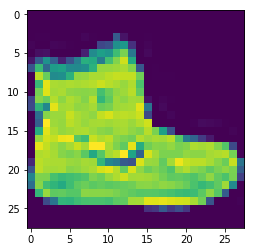

In [92]:
plt.imshow(np.fliplr(x_train[0,:,:,0]))
plt.show()

In [93]:
x_train_flip = np.zeros_like(x_train)

In [97]:
for i in range(x_train_flip.shape[0]):
    x_train_flip[i,:,:,0] = np.fliplr(x_train[i,:,:,0])

In [99]:
x_train = np.concatenate((x_train,x_train_flip),axis=0)

In [100]:
y_train = np.concatenate((y_train,y_train),axis=0)

### Model final

In [102]:
def create_model():
   
    cnn = Sequential()
    
    cnn.add(InputLayer(input_shape=(28,28,1)))
    
    # Normalization
    cnn.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(128, (4, 4), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(128, (4, 4), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(Flatten())

    # Fully Connected Layer
    cnn.add(Dense(256, activation='relu'))

    # Dropout
    cnn.add(Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(BatchNormalization())

    cnn.add(Dense(10, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

    return cnn

model = create_model()

number of parameters: 1101262


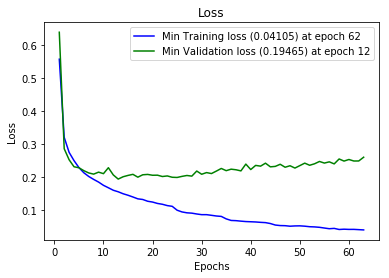

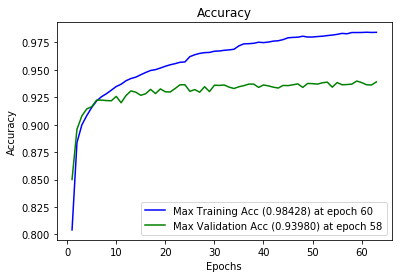

total time: 1214.3262186050415


In [103]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

#### Figure 24: Architecture choisie pour le test final

# Validation sur le test set

On prend l'epoch 58 pour avoir le meilleur accuracy

In [111]:
from sklearn.metrics import accuracy_score

In [114]:
model.fit(x_train, y_train, batch_size=512, epochs=58, verbose=0,callbacks=callbacks)

In [109]:
y_pred = model.predict(x_test)

### Accuracy final

In [113]:
print(accuracy_score(np.argmax(y_pred,axis=1),np.argmax(y_test,axis=1)))

0.9368
